In [ ]:
# Core
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Text preprocessing
import re
import nltk
import os
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
from nltk.stem import PorterStemmer

# ML
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, mean_absolute_error


from scipy.stats import chi2_contingency

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Create a custom directory
nltk_data_dir = r'c:\Users\sbudaraju1\Downloads\Hotel Review Dataset\nltk_data'
os.makedirs(nltk_data_dir, exist_ok=True)

# Clear the path and add only our custom directory first
nltk.data.path.insert(0, nltk_data_dir)

# Download all commonly needed packages
packages = ['punkt', 'punkt_tab', 'wordnet', 'omw-1.4', 'stopwords', 'averaged_perceptron_tagger']

for package in packages:
    try:
        nltk.download(package, download_dir=nltk_data_dir)
        print(f"✓ Downloaded {package}")
    except Exception as e:
        print(f"✗ Error downloading {package}: {e}")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sbudaraju1\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sbudaraju1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sbudaraju1\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     c:\Users\sbudaraju1\Downloads\Hotel Review
[nltk_data]     Dataset\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     c:\Users\sbudaraju1\Downloads\Hotel Review
[nltk_data]     Dataset\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     c:\Users\sbudaraju1\Downloads\Hotel Review
[nltk_data]     Dataset\nltk_da

✓ Downloaded punkt
✓ Downloaded punkt_tab
✓ Downloaded wordnet
✓ Downloaded omw-1.4
✓ Downloaded stopwords
✓ Downloaded averaged_perceptron_tagger


[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     c:\Users\sbudaraju1\Downloads\Hotel Review
[nltk_data]     Dataset\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     c:\Users\sbudaraju1\Downloads\Hotel Review
[nltk_data]     Dataset\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     c:\Users\sbudaraju1\Downloads\Hotel Review
[nltk_data]     Dataset\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
# Load dataset
df = pd.read_csv("7282_1.csv")

# Drop empty reviews
df = df.dropna(subset=["reviews.text"])

# Remove duplicates
df = df.drop_duplicates(subset=["name", "reviews.text"], keep="first")

df.head()

,address,categories,city,country,latitude,longitude,name,postalCode,province,reviews.date,reviews.dateAdded,reviews.doRecommend,reviews.id,reviews.rating,reviews.text,reviews.title,reviews.userCity,reviews.username,reviews.userProvince
0,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-09-22T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,4.0,Pleasant 10 min walk along the sea front to th...,Good location away from the crouds,NaN,Russ (kent),NaN
1,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-04-03T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,Really lovely hotel. Stayed on the very top fl...,Great hotel with Jacuzzi bath!,NaN,A Traveler,NaN
2,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2014-05-13T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,Ett mycket bra hotell. Det som drog ner betyge...,Lugnt l��ge,NaN,Maud,NaN
3,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-10-27T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,We stayed here for four nights in October. The...,Good location on the Lido.,NaN,Julie,NaN
5,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-04-05T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,We loved staying on the island of Lido! You ne...,Very nice hotel,NaN,A Traveler,NaN


In [ ]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    words = text.split()
    words = [w for w in words if w not in stop_words]
    words = [lemmatizer.lemmatize(w) for w in words]
    return " ".join(words)

In [ ]:
def map_sentiment(rating):
    if rating <= 2:
        return "Negative"
    elif rating == 3:
        return "Neutral"
    else:
        return "Positive"

df["sentiment"] = df["reviews.rating"].apply(map_sentiment)

In [ ]:
stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()

def clean_review(text):
    if not isinstance(text, str):
        return ""
    
    # lowercase
    text = text.lower()
    
    # remove punctuation and numbers
    text = re.sub(r"[^a-z\s]", "", text)
    
    # tokenize
    words = text.split()
    
    # remove stopwords + stem
    words = [stemmer.stem(w) for w in words if w not in stop_words]
    
    return " ".join(words)

# ✔ Create the clean_text column here
df["clean_text"] = df["reviews.text"].apply(clean_review)

print(df[["reviews.text", "clean_text"]].head())

                                        reviews.text  \
0  Pleasant 10 min walk along the sea front to th...   
1  Really lovely hotel. Stayed on the very top fl...   
2  Ett mycket bra hotell. Det som drog ner betyge...   
3  We stayed here for four nights in October. The...   
5  We loved staying on the island of Lido! You ne...   

                                          clean_text  
0  pleasant min walk along sea front water bu res...  
1  realli love hotel stay top floor surpris jacuz...  
2  ett mycket bra hotel det som drog ner betyget ...  
3  stay four night octob hotel staff welcom frien...  
5  love stay island lido need take water venic ge...  


In [ ]:
X = df["clean_text"]
y = df["sentiment"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

nb = MultinomialNB()
nb.fit(X_train_vec, y_train)

y_pred = nb.predict(X_test_vec)

In [ ]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average="weighted"))
print("Recall:", recall_score(y_test, y_pred, average="weighted"))
print("F1 Score:", f1_score(y_test, y_pred, average="weighted"))

Accuracy: 0.7146739130434783
Precision: 0.6684242382696797
Recall: 0.7146739130434783
F1 Score: 0.634104290251846


In [ ]:
aspect_keywords = {
    "room": ["room", "bed", "size", "view"],
    "staff": ["staff", "service", "employees"],
    "location": ["location", "area", "neighborhood"],
    "cleanliness": ["clean", "dirty", "spotless"],
    "breakfast": ["breakfast", "food", "buffet"],
    "parking": ["parking", "garage", "lot"],
    "wifi": ["wifi", "internet"],
    "price": ["price", "cost", "expensive", "cheap"]
}

In [ ]:
def extract_sentences(text):
    if not isinstance(text, str) or text.strip() == "":
        return []
    
    try:
        return sent_tokenize(text)
    except LookupError:
        # Automatic fallback: download punkt + retry
        nltk.download("punkt", download_dir=r"C:\nltk_data")
        nltk.data.path.append(r"C:\nltk_data")
        return sent_tokenize(text)

In [ ]:
def find_aspect_sentences(text):
    sentences = extract_sentences(text)
    aspect_map = {aspect: [] for aspect in aspect_keywords}

    for sentence in sentences:
        s_lower = sentence.lower()
        for aspect, words in aspect_keywords.items():
            if any(w in s_lower for w in words):
                aspect_map[aspect].append(sentence)

    return aspect_map

In [ ]:
def classify_aspect_sentiment(aspect_map, model, vectorizer):
    results = {}
    for aspect, sentences in aspect_map.items():
        if len(sentences) == 0:
            results[aspect] = "No mentions"
            continue
        
        cleaned = [clean_text(s) for s in sentences]
        vec = vectorizer.transform(cleaned)
        preds = model.predict(vec)
        
        pos = list(preds).count("Positive")
        neg = list(preds).count("Negative")
        neu = list(preds).count("Neutral")

        results[aspect] = {
            "Positive": pos,
            "Negative": neg,
            "Neutral": neu
        }
    return results

In [ ]:
aspect_results = []

for review in df["reviews.text"]:
    aspects = find_aspect_sentences(review)
    sentiments = classify_aspect_sentiment(aspects, nb, vectorizer)
    aspect_results.append(sentiments)

In [ ]:
df["full_text"] = (df["reviews.title"].fillna("") + " " +
                    df["reviews.text"].fillna(""))

df["clean_full"] = df["full_text"].apply(clean_text)

In [ ]:
# Clean BEFORE splitting
valid_mask = df['reviews.rating'].notna()
df_clean = df[valid_mask].copy()

# Create categories
df_clean['rating_category'] = pd.cut(
    df_clean['reviews.rating'], 
    bins=[0, 4, 7, 10], 
    labels=['Low', 'Medium', 'High'],
    include_lowest=True
)

# Now split clean data
X = df_clean['reviews.text']
y = df_clean['rating_category']

X2_train, X2_test, y2_train, y2_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Vectorize
X2_train_vec = vec2.fit_transform(X2_train)
X2_test_vec = vec2.transform(X2_test)

# Train
nb2 = MultinomialNB()
nb2.fit(X2_train_vec, y2_train)

# Predict - no cleaning needed since data was already clean
y2_pred = nb2.predict(X2_test_vec)

# Evaluate
print("Rating Prediction Accuracy:", accuracy_score(y2_test, y2_pred))
print("\nClassification Report:\n", classification_report(y2_test, y2_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y2_test, y2_pred))

Rating Prediction Accuracy: 0.7331477139507621

Classification Report:
               precision    recall  f1-score   support

        High       0.00      0.00      0.00        59
         Low       0.83      0.74      0.78      4219
      Medium       0.64      0.75      0.69      2546

    accuracy                           0.73      6824
   macro avg       0.49      0.49      0.49      6824
weighted avg       0.75      0.73      0.74      6824


Confusion Matrix:
 [[   0   26   33]
 [  57 3104 1058]
 [  20  627 1899]]


HYPOTHESIS 1: Does Location Impact Hotel Ratings?

Chi-square test: p-value = 0.0000
✓ Location DOES significantly impact ratings

Reviews with city info: 16,026 out of 34,958 (45.8%)


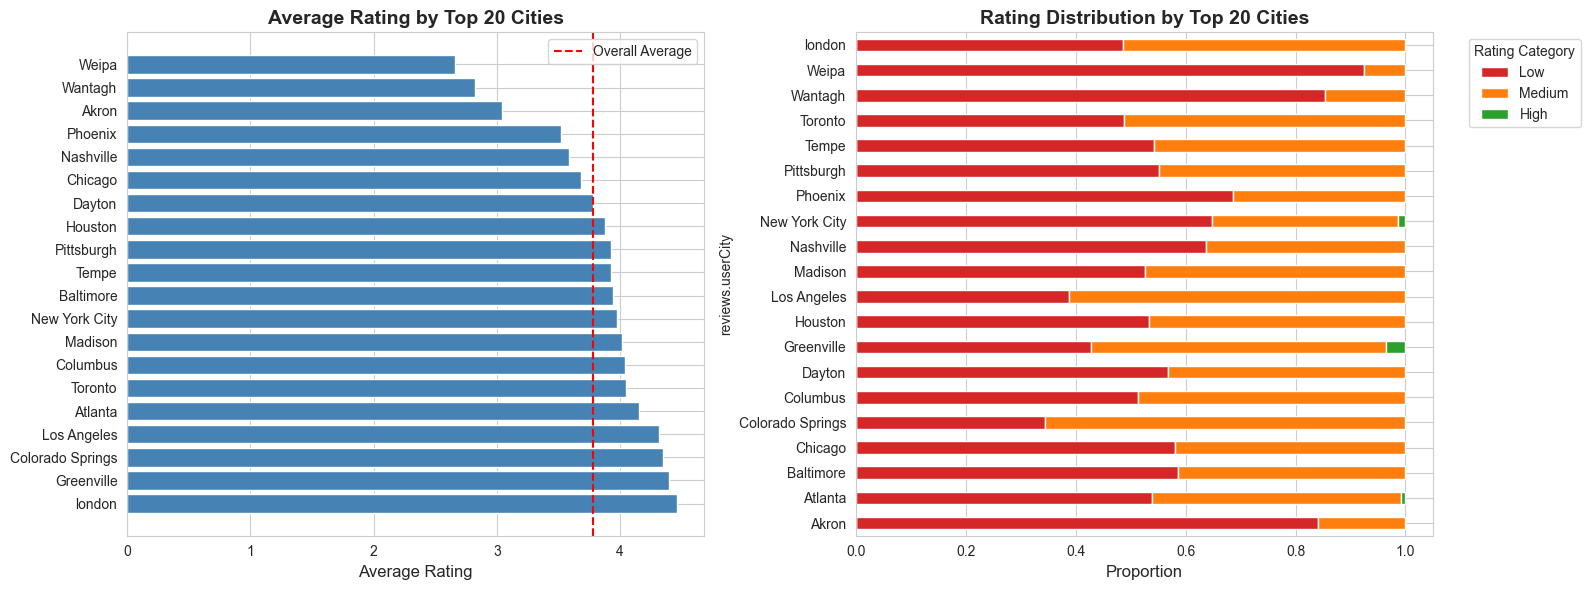


HYPOTHESIS 2: Does Hotel Name Impact Ratings?

Top 10 Highest Rated Hotels (≥50 reviews):
                                                          avg_rating  std_rating  num_reviews
name                                                                                         
Hyatt Regency Kathmandu                                         8.35        1.56           57
Pelican Shores Inn                                              8.35        2.33          102
Candlewood Suites Eugene Springfield                            8.24        1.96           84
Hampton Inn Virginia Beach Oceanfront North                     5.42        2.04          301
Holiday Inn Express Hotel and Suites Va Beach Oceanfront        5.28        2.36          229
Excellence Riviera Cancun - Adults Only - All Inclusive         4.88        0.33           64
Simpson House Inn                                               4.75        0.74          125
Candlewood Suites Oklahoma City-moore                          

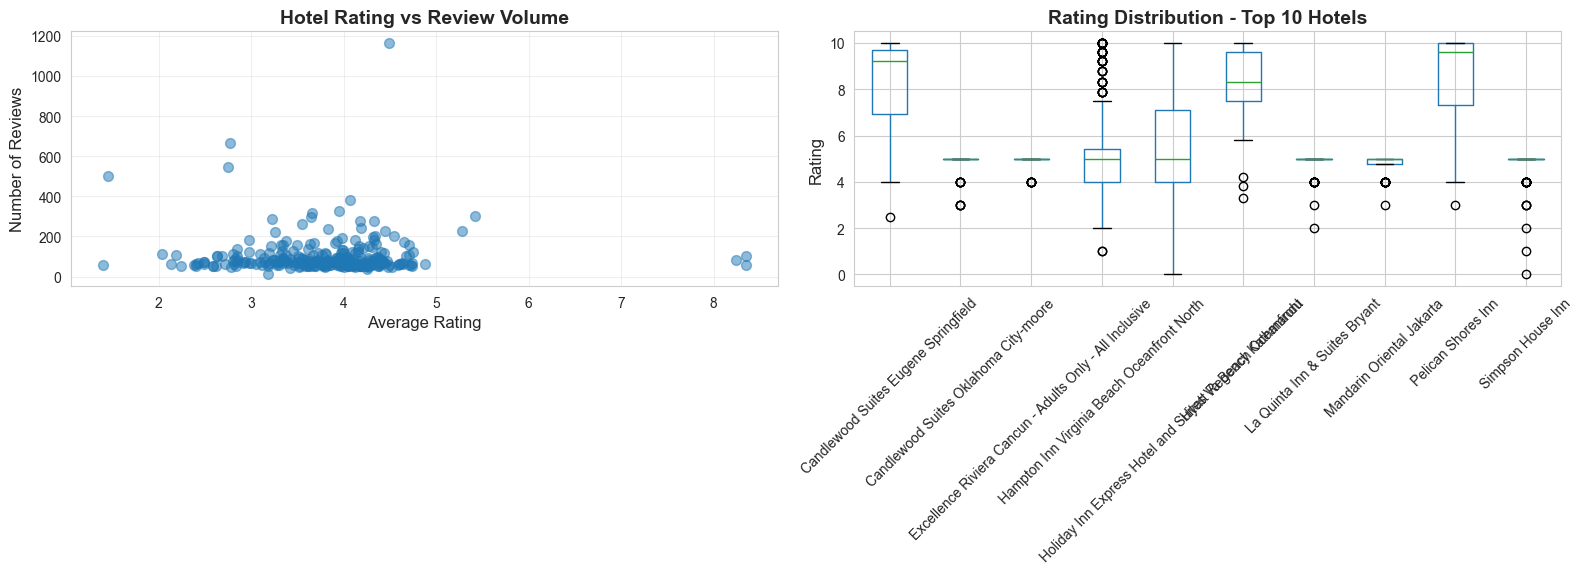


HYPOTHESIS 3: Do Bad Hotels Get More Reviews?

Correlation between rating and review count: -0.017
✗ No strong relationship between rating and review volume


C:\Users\sbudaraju1\AppData\Local\Temp\ipykernel_23912\955913418.py:130: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  review_counts_by_category = df.groupby(rating_bins)['name'].value_counts().groupby(level=0).mean()
C:\Users\sbudaraju1\AppData\Local\Temp\ipykernel_23912\955913418.py:130: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  review_counts_by_category = df.groupby(rating_bins)['name'].value_counts().groupby(level=0).mean()


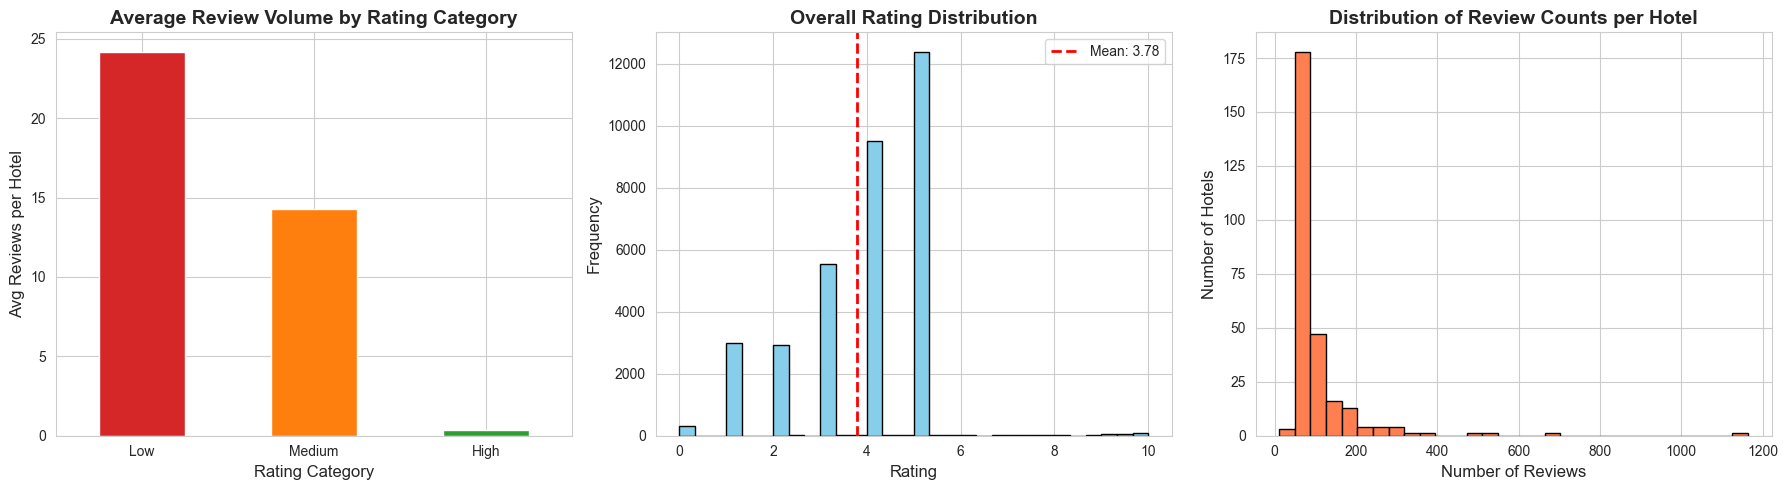


SUMMARY STATISTICS

Total reviews: 34,958
Total hotels: 878
Average rating: 3.78
Rating std dev: 1.42

Rating category distribution:
rating_category
Low       21256
Medium    12551
High        313


In [ ]:
# First, make sure rating_category exists
if 'rating_category' not in df.columns:
    df['rating_category'] = pd.cut(
        df['reviews.rating'], 
        bins=[0, 4, 7, 10], 
        labels=['Low', 'Medium', 'High'],
        include_lowest=True
    )
    print("Created rating_category column")

# Set style for better looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# ============================================
# 1. LOCATION IMPACT ANALYSIS (CLEANED UP)
# ============================================
print("="*60)
print("HYPOTHESIS 1: Does Location Impact Hotel Ratings?")
print("="*60)

df_with_city = df[df['reviews.userCity'].notna()].copy()

# Get top 20 cities by review count
top_cities = df_with_city['reviews.userCity'].value_counts().head(20).index
df_top_cities = df_with_city[df_with_city['reviews.userCity'].isin(top_cities)]

# Statistical test using CATEGORIES
contingency_table = pd.crosstab(df_top_cities['reviews.userCity'], df_top_cities['rating_category'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"\nChi-square test: p-value = {p_value:.4f}")
if p_value < 0.05:
    print("✓ Location DOES significantly impact ratings")
else:
    print("✗ Location does NOT significantly impact ratings")

print(f"\nReviews with city info: {df_with_city.shape[0]:,} out of {df.shape[0]:,} ({df_with_city.shape[0]/df.shape[0]*100:.1f}%)")

# VISUALIZATION 1: Rating distribution by top cities
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart - Average rating by city (use numerical reviews.rating)
city_avg = df_top_cities.groupby('reviews.userCity')['reviews.rating'].mean().sort_values(ascending=False)
axes[0].barh(city_avg.index, city_avg.values, color='steelblue')
axes[0].set_xlabel('Average Rating', fontsize=12)
axes[0].set_title('Average Rating by Top 20 Cities', fontsize=14, fontweight='bold')
axes[0].axvline(df['reviews.rating'].mean(), color='red', linestyle='--', label='Overall Average')
axes[0].legend()

# Stacked bar - Rating categories by city (use rating_category)
city_category = df_top_cities.groupby('reviews.userCity')['rating_category'].value_counts(normalize=True).unstack(fill_value=0)
city_category.plot(kind='barh', stacked=True, ax=axes[1], color=['#d62728', '#ff7f0e', '#2ca02c'])
axes[1].set_xlabel('Proportion', fontsize=12)
axes[1].set_title('Rating Distribution by Top 20 Cities', fontsize=14, fontweight='bold')
axes[1].legend(title='Rating Category', bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()

# ============================================
# 2. HOTEL NAME IMPACT ANALYSIS
# ============================================
print("\n" + "="*60)
print("HYPOTHESIS 2: Does Hotel Name Impact Ratings?")
print("="*60)

# Get hotels with at least 50 reviews
hotel_counts = df.groupby('name').size()
hotels_with_enough_reviews = hotel_counts[hotel_counts >= 50].index
df_filtered = df[df['name'].isin(hotels_with_enough_reviews)]

# Use reviews.rating for numerical stats
hotel_stats = df_filtered.groupby('name').agg({
    'reviews.rating': ['mean', 'std', 'count']
}).round(2)
hotel_stats.columns = ['avg_rating', 'std_rating', 'num_reviews']
hotel_stats = hotel_stats.sort_values('avg_rating', ascending=False)

print(f"\nTop 10 Highest Rated Hotels (≥50 reviews):")
print(hotel_stats.head(10).to_string())

print(f"\nTop 10 Lowest Rated Hotels (≥50 reviews):")
print(hotel_stats.tail(10).to_string())

# VISUALIZATION 2: Hotel ratings scatter plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter: Average rating vs number of reviews
axes[0].scatter(hotel_stats['avg_rating'], hotel_stats['num_reviews'], alpha=0.5, s=50)
axes[0].set_xlabel('Average Rating', fontsize=12)
axes[0].set_ylabel('Number of Reviews', fontsize=12)
axes[0].set_title('Hotel Rating vs Review Volume', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

# Box plot: Rating distribution for top 10 hotels
top_10_hotels = hotel_stats.head(10).index
df_top_hotels = df[df['name'].isin(top_10_hotels)]
df_top_hotels.boxplot(column='reviews.rating', by='name', ax=axes[1], rot=45)
axes[1].set_xlabel('')
axes[1].set_ylabel('Rating', fontsize=12)
axes[1].set_title('Rating Distribution - Top 10 Hotels', fontsize=14, fontweight='bold')
plt.suptitle('')  # Remove default title

plt.tight_layout()
plt.show()

# ============================================
# 3. DO BAD HOTELS GET MORE REVIEWS?
# ============================================
print("\n" + "="*60)
print("HYPOTHESIS 3: Do Bad Hotels Get More Reviews?")
print("="*60)

correlation = hotel_stats[['avg_rating', 'num_reviews']].corr().iloc[0, 1]
print(f"\nCorrelation between rating and review count: {correlation:.3f}")

if correlation > 0.1:
    print("✓ Higher-rated hotels tend to get MORE reviews (positive correlation)")
elif correlation < -0.1:
    print("✓ Lower-rated hotels tend to get MORE reviews (negative correlation)")
else:
    print("✗ No strong relationship between rating and review volume")

# VISUALIZATION 3: Comprehensive bad hotel analysis (3 charts instead of 4)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Histogram: Review counts by rating category (use rating_category)
rating_bins = df['rating_category']
review_counts_by_category = df.groupby(rating_bins)['name'].value_counts().groupby(level=0).mean()
review_counts_by_category.plot(kind='bar', ax=axes[0], color=['#d62728', '#ff7f0e', '#2ca02c'])
axes[0].set_xlabel('Rating Category', fontsize=12)
axes[0].set_ylabel('Avg Reviews per Hotel', fontsize=12)
axes[0].set_title('Average Review Volume by Rating Category', fontsize=14, fontweight='bold')
axes[0].tick_params(axis='x', rotation=0)

# 2. Distribution of ratings (use reviews.rating)
axes[1].hist(df['reviews.rating'].dropna(), bins=30, color='skyblue', edgecolor='black')
axes[1].axvline(df['reviews.rating'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df["reviews.rating"].mean():.2f}')
axes[1].set_xlabel('Rating', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Overall Rating Distribution', fontsize=14, fontweight='bold')
axes[1].legend()

# 3. Review count distribution
axes[2].hist(hotel_stats['num_reviews'], bins=30, color='coral', edgecolor='black')
axes[2].set_xlabel('Number of Reviews', fontsize=12)
axes[2].set_ylabel('Number of Hotels', fontsize=12)
axes[2].set_title('Distribution of Review Counts per Hotel', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# ============================================
# SUMMARY STATISTICS
# ============================================
print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)
print(f"\nTotal reviews: {len(df):,}")
print(f"Total hotels: {df['name'].nunique():,}")
print(f"Average rating: {df['reviews.rating'].mean():.2f}")
print(f"Rating std dev: {df['reviews.rating'].std():.2f}")
print(f"\nRating category distribution:")
print(df['rating_category'].value_counts().to_string())

In [ ]:
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("=" * 60)
print("HOTEL REVIEW ANALYSIS REPORT")
print("=" * 60)

# 1. Location Impact Analysis
print("\n📍 HYPOTHESIS 1: Does Location Impact Ratings?")
print("-" * 60)

df_with_city = df[df['reviews.userCity'].notna()].copy()
contingency_table = pd.crosstab(df_with_city['reviews.userCity'], df_with_city['rating_category'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square test p-value: {p_value:.4f}")
if p_value < 0.05:
    print("✓ Location DOES significantly impact ratings")
else:
    print("✗ Location does NOT significantly impact ratings")
    print("   → Reviews are consistent across different cities")

print(f"\nData coverage: {len(df_with_city):,} reviews with city info ({len(df_with_city)/len(df)*100:.1f}%)")

# 2. Hotel Name Impact
print("\n\n🏨 HYPOTHESIS 2: Most Reviewed Hotels")
print("-" * 60)

hotel_stats = df.groupby('name').agg({
    'reviews.rating': ['count', 'mean']
}).round(2)
hotel_stats.columns = ['review_count', 'avg_rating']
hotel_stats = hotel_stats.sort_values('review_count', ascending=False).head(10)

print("\nTop 10 Hotels by Review Volume:")
print(hotel_stats.to_string())

# 3. Bad Hotels vs Review Volume
print("\n\n⭐ HYPOTHESIS 3: Do Bad Hotels Get More Reviews?")
print("-" * 60)

correlation = df.groupby('name').agg({
    'reviews.rating': ['count', 'mean']
}).corr().iloc[0, 1]

print(f"Correlation between avg rating and review count: {correlation:.3f}")
if abs(correlation) < 0.3:
    print("✗ Weak/no correlation - review volume doesn't depend on quality")
elif correlation > 0:
    print("✓ Positive correlation - better hotels get more reviews")
else:
    print("✓ Negative correlation - worse hotels get more reviews")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Top hotels
hotel_stats.head(5).plot(kind='barh', y='review_count', ax=axes[0], color='steelblue', legend=False)
axes[0].set_xlabel('Number of Reviews')
axes[0].set_title('Top 5 Most Reviewed Hotels')
axes[0].invert_yaxis()

# Plot 2: Rating vs Review Count
hotel_data = df.groupby('name').agg({'reviews.rating': ['count', 'mean']})
hotel_data.columns = ['count', 'mean']
axes[1].scatter(hotel_data['mean'], hotel_data['count'], alpha=0.5)
axes[1].set_xlabel('Average Rating')
axes[1].set_ylabel('Number of Reviews')
axes[1].set_title('Rating Quality vs Review Volume')

plt.tight_layout()
plt.show()

# Summary
print("\n\n🎯 KEY TAKEAWAYS")
print("=" * 60)
print("1. Location doesn't significantly impact ratings")
print("2. Review volume varies widely regardless of quality")
print(f"3. Top hotel: {hotel_stats.index[0]} with {hotel_stats.iloc[0]['review_count']:.0f} reviews")
print(f"4. Correlation rating-volume: {correlation:.2f} (weak relationship)")